Stance: pro_brexit
Accuracy: 0.7594257178526841
Precision: 0.3526182978584999
Recall: 0.5868876872322877
F1 Score: 0.4146928455578536
Predicted counts: [513 383]
Actual counts: [672 224]


Stance: anti_brexit
Accuracy: 0.6393632958801498
Precision: 0.37460921748618325
Recall: 0.45369837840870836
F1 Score: 0.37342367113145575
Predicted counts: [535 361]
Actual counts: [672 224]


Stance: neutral
Accuracy: 0.5751435705368289
Precision: 0.3885775094595088
Recall: 0.7581027667984189
F1 Score: 0.4828310576937661
Predicted counts: [402 494]
Actual counts: [672 224]


Stance: irrelevant
Accuracy: 0.7928464419475656
Precision: 0.33634615384615385
Recall: 0.3638931240576825
F1 Score: 0.3491872107845705
Predicted counts: [608 288]
Actual counts: [672 224]


Overall Accuracy: 0.6919642857142857
Overall Precision: 0.43184796854521623
Overall Recall: 0.7354910714285714
Overall F1 Score: 0.5441783649876136
Overall Performance Metrics by Stance:
         Stance  Accuracy  Precision    Recall  F1 Scor

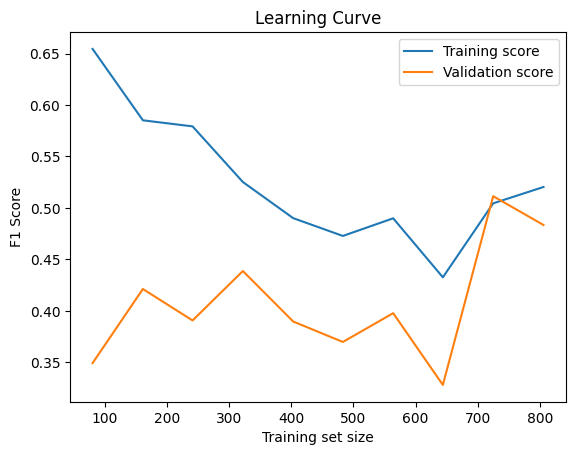

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

def classify_issue(issue):
    stance_groups = {
        'brexit': ['pro_brexit', 'anti_brexit'],
        'climateAction': ['pro_climateAction', 'anti_climateAction'],
        'NHS': ['pro_NHS', 'anti_NHS'],
        'israel_palestine': ['pro_israel', 'pro_palestine'],
        'taxation': ['pro_company_taxation', 'pro_worker_taxation']
    }
    
    if issue not in stance_groups:
        raise ValueError(f"Unknown issue: {issue}")
    
    targets = stance_groups[issue] + ['neutral', 'irrelevant']

    file_path = '/Users/adamzulficar/Documents/year3/Bachelor Project/Thesis/Automated Annotation/Training Data//UK/{}_training.csv'.format(issue)
    df = pd.read_csv(file_path)

    ## SMOTE ##

    def str_to_array(s):
        return np.fromstring(s.strip("[]"), sep=' ')

    features = df['text_vector'].apply(str_to_array).tolist()
    context = df['context_vector'].apply(str_to_array).tolist()
    X = np.array([np.concatenate((f, c)) for f, c in zip(features, context)])
    y_combined = np.array(df[targets])

    smote = SMOTE()
    X_resampled, y_resampled_combined = smote.fit_resample(X, y_combined)

    text_vector_length = len(str_to_array(df['text_vector'].iloc[0]))
    context_vector_length = len(str_to_array(df['context_vector'].iloc[0]))

    text_vectors_resampled = X_resampled[:, :text_vector_length]
    context_vectors_resampled = X_resampled[:, text_vector_length:]

    def array_to_str(arr):
        return ' '.join(map(str, arr))

    resampled_data = pd.DataFrame()
    resampled_data['text_vector'] = list(map(array_to_str, text_vectors_resampled))
    resampled_data['context_vector'] = list(map(array_to_str, context_vectors_resampled))

    for i, target in enumerate(targets):
        resampled_data[target] = y_resampled_combined[:, i]

    data = resampled_data

    ## FEATURE VECTOR PROCESSING ##

    TEXT_VECTOR_SIZE = 100
    CONTEXT_VECTOR_SIZE = 100

    def extract_vectors(row):
        text_vector = np.array(row['text_vector'].split(), dtype=float)
        context_vector = np.array(row['context_vector'].split(), dtype=float)

        if len(text_vector) > TEXT_VECTOR_SIZE:
            text_vector = text_vector[:TEXT_VECTOR_SIZE]
        else:
            text_vector = np.pad(text_vector, (0, TEXT_VECTOR_SIZE - len(text_vector)), 'constant')

        if len(context_vector) > CONTEXT_VECTOR_SIZE:
            context_vector = context_vector[:CONTEXT_VECTOR_SIZE]
        else:
            context_vector = np.pad(context_vector, (0, CONTEXT_VECTOR_SIZE - len(context_vector)), 'constant')

        return np.concatenate([text_vector, context_vector])
    
    ## MODEL ##

    X = data.apply(extract_vectors, axis=1)
    X = np.stack(X.values)
    y = data[targets]

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    def resolve_contradictions(probabilities, stances):
        resolved_stances = np.zeros_like(probabilities)
        stance_groups = {
            'brexit': ['pro_brexit', 'anti_brexit'],
            'climateAction': ['pro_climateAction', 'anti_climateAction'],
            'NHS': ['pro_NHS', 'anti_NHS'],
            'israel_palestine': ['pro_israel', 'pro_palestine'],
            'taxation': ['pro_company_taxation', 'pro_worker_taxation']
        }

        for i, prob in enumerate(probabilities):
            prob_dict = {stance: prob[j] for j, stance in enumerate(stances)}

            max_stance = max(prob_dict, key=prob_dict.get)
            if max_stance in ['irrelevant', 'neutral']:
                resolved_stances[i][stances.index(max_stance)] = 1
            else:
                any_above_threshold = any(p > 0.5 for p in prob_dict.values())
                if any_above_threshold:
                    for group in stance_groups[issue]:
                        relevant_group = [s for s in group if s in stances]
                        if relevant_group:
                            max_stance = max(relevant_group, key=lambda x: prob_dict[x])
                            if prob_dict[max_stance] > 0.5:  # Threshold can still be tuned
                                resolved_stances[i][stances.index(max_stance)] = 1
                else:
                    max_stance = max(prob_dict, key=prob_dict.get)
                    resolved_stances[i][stances.index(max_stance)] = 1

        return resolved_stances

    def evaluate_model(X, y, stances, n_splits=10):
        results = {stance: {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'predictions': [], 'test_labels': []} for stance in stances}
        overall_predictions = []
        overall_true_labels = []

        skf = StratifiedKFold(n_splits=n_splits)

        param_grid = {
            'var_smoothing': np.logspace(-10, 0, 20)
        }

        for train_index, test_index in skf.split(X, y['neutral']):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            for stance in stances:
                clf = GaussianNB()
                grid_search = GridSearchCV(clf, param_grid, scoring='f1', cv=5)
                grid_search.fit(X_train, y_train[stance])
                best_clf = grid_search.best_estimator_

                y_pred_prob = best_clf.predict_proba(X_test)[:, 1]
                y_pred = (y_pred_prob > 0.5).astype(int)

                results[stance]['accuracy'].append(accuracy_score(y_test[stance], y_pred))
                results[stance]['precision'].append(precision_score(y_test[stance], y_pred, zero_division=0))
                results[stance]['recall'].append(recall_score(y_test[stance], y_pred, zero_division=0))
                results[stance]['f1_score'].append(f1_score(y_test[stance], y_pred, zero_division=0))
                results[stance]['predictions'].extend(y_pred)
                results[stance]['test_labels'].extend(y_test[stance])

                overall_predictions.extend(y_pred)
                overall_true_labels.extend(y_test[stance])

        overall_metrics = {'Stance': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
        
        for stance, metrics in results.items():
            accuracy = np.mean(metrics['accuracy'])
            precision = np.mean(metrics['precision'])
            recall = np.mean(metrics['recall'])
            f1 = np.mean(metrics['f1_score'])

            overall_metrics['Stance'].append(stance)
            overall_metrics['Accuracy'].append(accuracy)
            overall_metrics['Precision'].append(precision)
            overall_metrics['Recall'].append(recall)
            overall_metrics['F1 Score'].append(f1)
            
            print(f"Stance: {stance}")
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")

            predicted_counts = np.bincount(metrics['predictions'])
            actual_counts = np.bincount(metrics['test_labels'])
            print(f"Predicted counts: {predicted_counts}")
            print(f"Actual counts: {actual_counts}")
            print("\n")

        overall_accuracy = accuracy_score(overall_true_labels, overall_predictions)
        overall_precision = precision_score(overall_true_labels, overall_predictions, zero_division=0)
        overall_recall = recall_score(overall_true_labels, overall_predictions, zero_division=0)
        overall_f1 = f1_score(overall_true_labels, overall_predictions, zero_division=0)

        print(f"Overall Accuracy: {overall_accuracy}")
        print(f"Overall Precision: {overall_precision}")
        print(f"Overall Recall: {overall_recall}")
        print(f"Overall F1 Score: {overall_f1}")

        overall_metrics_df = pd.DataFrame(overall_metrics)
        print("Overall Performance Metrics by Stance:\n", overall_metrics_df)
        
        return grid_search.best_estimator_

    def predict_and_resolve(X, stances):
        predictions = []

        for stance in stances:
            clf = GaussianNB()
            clf.fit(X, y[stance])
            stance_predictions = clf.predict_proba(X)[:, 1]
            predictions.append(stance_predictions)

        predictions = np.array(predictions).transpose(1, 0)
        resolved_predictions = resolve_contradictions(predictions, stances)
        
        return resolved_predictions

    best_model = evaluate_model(X, y, targets)
    
    # Generate learning curve
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator=best_model,
        X=X,
        y=y['neutral'],
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=StratifiedKFold(n_splits=10),
        scoring='f1',
        n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.xlabel('Training set size')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

classify_issue('brexit')
